# EECE 7398: Verifiable Machine Learning -- Fall 2025
# Exercise #1: Adversarial Examples & Decision Boundaries

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

# Problem 1: Train & Attack an MNIST Classifier

## 1a) Train an MNIST Classifier

To start, train a NN classifier that consists of:
- a "Flatten" layer to convert the (28, 28) images to (784,)
- a fully connected layer with 128 neurons and ReLU activation
- a fully connected (output) layer with 10 neurons (10 neurons for 10 digit categories)
- (optionally) a softmax layer to convert logits to probabilities

You can use the Adam optimizer with cross entropy loss (make sure to use the correct loss depending on whether you included a softmax layer) and it should work pretty well.

**Deliverables**:
- Plot your train and validation loss curves as a function of epoch
- From a test set, provide some examples where your classifier predicted correctly & incorrectly (if applicable)

Epoch 0/10, Train Loss: 0.32567160400390627 , Validaye Loss: 0.18732388751506807
Epoch 1/10, Train Loss: 0.14392249949216843 , Validaye Loss: 0.147103096473217
Epoch 2/10, Train Loss: 0.10056004801750183 , Validaye Loss: 0.12237085646390915
Epoch 3/10, Train Loss: 0.07694924373149872 , Validaye Loss: 0.10549066091477871
Epoch 4/10, Train Loss: 0.05912725544452667 , Validaye Loss: 0.09444403418898582
Epoch 5/10, Train Loss: 0.04875538697361946 , Validaye Loss: 0.0917328810453415
Epoch 6/10, Train Loss: 0.03773325207710266 , Validaye Loss: 0.10071863844096661
Epoch 7/10, Train Loss: 0.031363696746826174 , Validaye Loss: 0.09477490378171205
Epoch 8/10, Train Loss: 0.027127601934075356 , Validaye Loss: 0.09614018841534853
Epoch 9/10, Train Loss: 0.021613561984300613 , Validaye Loss: 0.08880330695770682


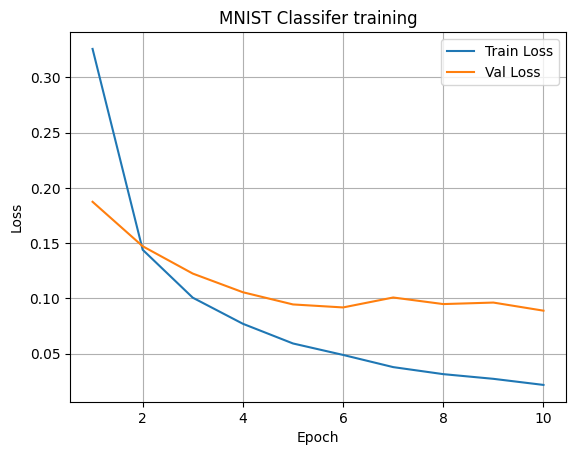

In [8]:
# mnist_mlp.py
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#--------------------------------------------------
#PARAMS AND CONSTANTS

#Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

#params
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 10
VAL_SPLIT = 10_000  # 50k train / 10k val from 6ok total

#--------------------------------------------------
# GET TRAINING, VALIDATING, AND TESTING DATA

# Data: MNIST (28x28 grayscale)
transform = transforms.Compose([
    transforms.ToTensor(),               # -> tensor in range [0, 1], with shape (1, 28, 28)
    transforms.Normalize((0.1307,), (0.3081,))  #Standard for MNIST??? -> normalize inputs to distribution with mean = 0 and std = 1.
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data     = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split train into train/val
train_len = len(train_data) - VAL_SPLIT
val_len   = VAL_SPLIT
train_data, val_data = random_split(train_data, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

#--------------------------------------------------
# SET UP NN MODEL
# !!!
# - a "Flatten" layer to convert the (28, 28) images to (784,)
# - a fully connected layer with 128 neurons and ReLU activation
# - a fully connected (output) layer with 10 neurons (10 neurons for 10 digit categories)my_pc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_pc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Flatten(),                 # (N, 1, 28, 28) -> (N, 784)
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)           # logits for 10 classes
).to(my_pc)


#--------------------------------------------------
#TRAINING AND EVALUATING FOR 10 EPOCHS

# !!! You can use the Adam optimizer with cross entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training / Validation loops
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, my_pc)
    va_loss = eval_loss(model, val_loader, criterion, my_pc)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    print(f"Epoch {epoch}/{EPOCHS}, Train Loss: {tr_loss} , Validaye Loss: {va_loss}")

#--------------------------------------------------


plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MNIST Classifer training")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 97.72999882698059%


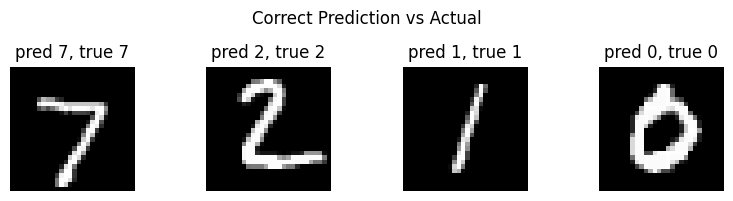

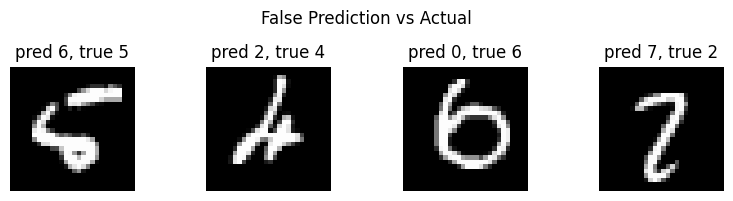

In [9]:
#----------------------------------
#EVALUATE TESTING DATA

model.eval()
all_images = []
all_preds = []
all_labels = []
for x, y in test_loader:
    logits = model(x.to(my_pc))
    preds = logits.argmax(dim=1).cpu()
    all_images.append(x)             # still on CPU
    all_preds.append(preds)
    all_labels.append(y)
images = torch.cat(all_images, dim=0)
preds  = torch.cat(all_preds,  dim=0)
labels = torch.cat(all_labels, dim=0)

accuracy = (preds == labels).float().mean().item()
print(f"Test Accuracy: {accuracy*100}%")

#----------------------------------

correct_idx   = (preds == labels).nonzero(as_tuple=True)[0]


if len(correct_idx) > 0:
  fig, axes = plt.subplots(1, 4, figsize=(2*4, 2))
  fig.suptitle("Correct Prediction vs Actual")
  for i, ax in zip(correct_idx[:4], axes):   #PLOT ONLY 4 EXAMPLES
      img = images[i].squeeze(0)  # (28, 28)
      ax.imshow(img, cmap="gray")
      ax.axis("off")
      ax.set_title(f"pred {preds[i].item()}, true {labels[i].item()}")
  plt.tight_layout()
  plt.show()

#----------------------------------

incorrect_idx = (preds != labels).nonzero(as_tuple=True)[0]

if len(incorrect_idx) > 0:
  fig, axes = plt.subplots(1, 4, figsize=(2*4, 2))
  fig.suptitle("False Prediction vs Actual")
  for i, ax in zip(incorrect_idx[:4], axes):   #PLOT ONLY 4 EXAMPLES
      img = images[i].squeeze(0)  # (28, 28)
      ax.imshow(img, cmap="gray")
      ax.axis("off")
      ax.set_title(f"pred {preds[i].item()}, true {labels[i].item()}")
  plt.tight_layout()
  plt.show()


## 1b) Attack your MNIST classifier with constant offsets

Add a constant perturbation to your test set images (e.g., c*torch.ones(28, 28)) and evaluate the performance as the magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- Provide some examples where the un-perturbed image was labeled correctly and the perturbed image was labeled incorrectly, despite the perturbed image looking reasonable to a human.

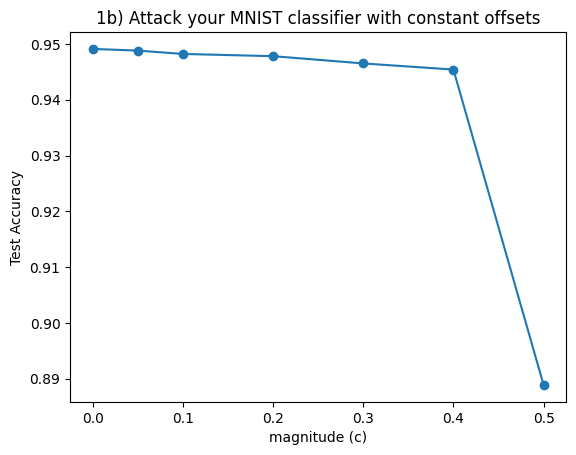

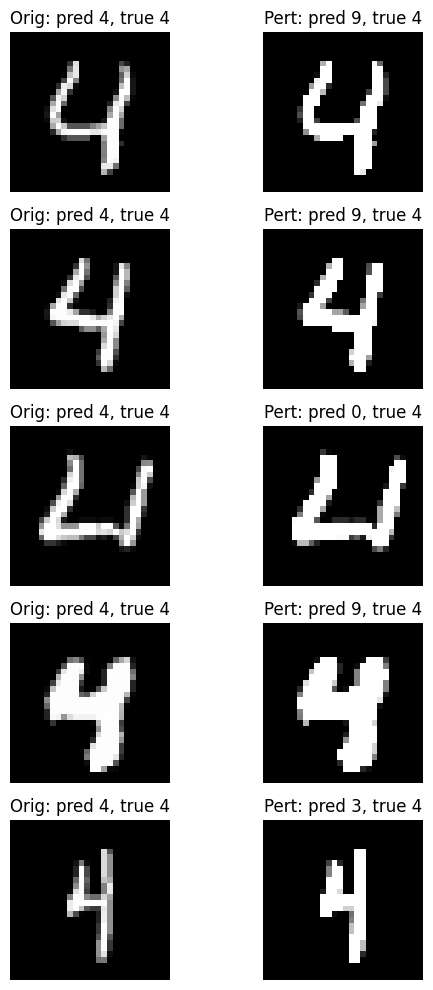

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

#SAME MODEL FROM FIRST PART -> not gonna redefine here. PLease run the above block first

# EVALUATING TEST DATA
def evaluate(model, loader, device, c):
    model.eval()
    correct, total = 0, 0
    bad_examples = []  # to save some wrong predictions
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            x_perturbed = x + c * torch.ones_like(x) # add constant offset
            x_perturbed = torch.clamp(x_perturbed, 0.0, 1.0) # clip predicted pixels to [0,1]

            logits = model(x_perturbed)
            preds = logits.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)


            if len(bad_examples) < 5:  # limit to 5 for display

                # check original prediction
                logits_orig = model(x)
                preds_orig = logits_orig.argmax(dim=1)

                for i in range(len(y)):

                    # save bad examples where original was correct but perturbed was wrong
                    if preds_orig[i] == y[i] and preds[i] != y[i]:
                        bad_examples.append((
                            x[i].cpu(), x_perturbed[i].cpu(),
                            preds_orig[i].item(), preds[i].item(), y[i].item()
                        ))
                        if len(bad_examples) >= 5:
                            break

    acc = correct / total
    return acc, bad_examples


magnitudes = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []

for c in magnitudes:
    acc, bad_examples = evaluate(model, test_loader, my_pc, c)
    accuracies.append(acc)

plt.figure()
plt.plot(magnitudes, accuracies, marker="o")
plt.xlabel("magnitude (c)")
plt.ylabel("Test Accuracy")
plt.title("1b) Attack your MNIST classifier with constant offsets")
plt.show()

# - Provide some examples where the un-perturbed image was labeled correctly and the perturbed image was labeled incorrectly,
# despite the perturbed image looking reasonable to a human.
if bad_examples is not None:
    # print(bad_examples)
    fig, axes = plt.subplots(len(bad_examples), 2, figsize=(6, 2*len(bad_examples)))

           # x[i].cpu(), x_perturbed[i].cpu(), preds_orig[i].item(), preds[i].item(), y[i].item()
    for i, (orig, pert, pred_orig, pred_pert, label) in enumerate(bad_examples):
        axes[i,0].imshow(orig.squeeze(), cmap="gray")
        axes[i,0].axis("off")
        axes[i,0].set_title(f"Orig: pred {pred_orig}, true {label}")
        axes[i,1].imshow(pert.squeeze(), cmap="gray")
        axes[i,1].axis("off")
        axes[i,1].set_title(f"Pert: pred {pred_pert}, true {label}")
    plt.show()


## 1c) Attack your MNIST classifier with noise

Add some noise perturbations to your test set images and evaluate the performance as the noise magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about any differences observed with constant perturbations vs. noise perturbations

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Gaussian noise with mag 0.0: test acc = 97.72999999999999%
Gaussian noise with mag 0.05: test acc = 97.64%
Gaussian noise with mag 0.1: test acc = 97.52%
Gaussian noise with mag 0.2: test acc = 96.39%
Gaussian noise with mag 0.3: test acc = 92.4%
Gaussian noise with mag 0.4: test acc = 83.97%
Gaussian noise with mag 0.5: test acc = 71.87%


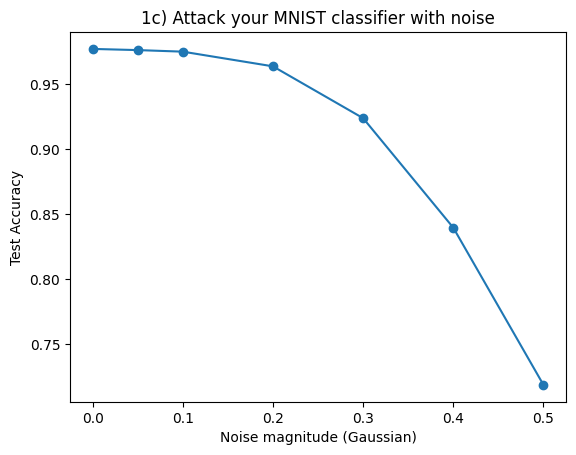

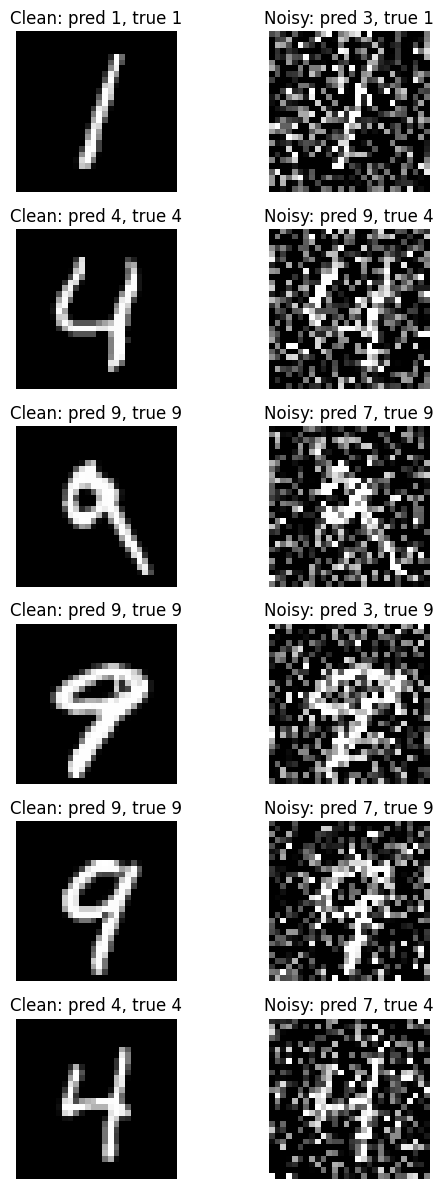

In [15]:
import torch
import matplotlib.pyplot as plt

def add_noise(x_pix, magnitude):

    #Add Guassian Noise
    noise = magnitude * torch.randn_like(x_pix)
    x_noisy = x_pix + noise

    # Clip to valid pixel range
    x_noisy = torch.clamp(x_noisy, 0.0, 1.0)
    return x_noisy

@torch.no_grad()
def evaluate(model, loader, device, magnitude, max_examples=6):
    model.eval()
    correct, total = 0, 0
    bad_examples = []  # (clean_pix, noisy_pix, pred_clean, pred_noisy, label)

    MNIST_MEAN = 0.1307
    MNIST_STD  = 0.3081

    for x_norm, y in loader:
        x_norm = x_norm.to(device)
        y = y.to(device)

        #turn x in Normal(MEAN,STD) to [0,1] pixel range
        x_pix = x_norm * MNIST_STD + MNIST_MEAN

        #Add noise with different magnitudes
        x_noisy_pix = add_noise(x_pix, magnitude)

        #Re-normalize to standard MNIST
        x_noisy = (x_noisy_pix - MNIST_MEAN) / MNIST_STD

        # Predictions
        logits_noisy = model(x_noisy)
        preds_noisy = logits_noisy.argmax(dim=1)

        correct += (preds_noisy == y).sum().item()
        total += y.size(0)

        #Look for bad example
        if len(bad_examples) < max_examples:

            logits_clean = model(x_norm)
            preds_clean = logits_clean.argmax(dim=1)

            # save bad examples where original was correct but perturbed was wrong
            mismatch = (preds_clean == y) & (preds_noisy != y)
            if mismatch.any():
                idxs = torch.nonzero(mismatch).squeeze(1)
                for i in idxs:
                    if len(bad_examples) >= max_examples:
                        break
                    bad_examples.append((
                        x_pix[i].cpu(),         # clean pixels
                        x_noisy_pix[i].cpu(),   # noisy pixels

                        preds_clean[i].item(),
                        preds_noisy[i].item(),
                        y[i].item()
                    ))

    acc = correct / total
    return acc, bad_examples


#EVALUATE TESTING DATA WITH GAUSSIAN NOISE
magnitudes = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
accs = []

for m in magnitudes:
    acc, ex = evaluate(model, test_loader, my_pc, m)
    accs.append(acc)
    print(f"Gaussian noise with mag {m}: test acc = {acc*100}%")

    saved_examples = ex

plt.figure()
plt.plot(magnitudes, accs, marker='o')
plt.xlabel("Noise magnitude (Gaussian)")
plt.ylabel("Test Accuracy")
plt.title("1c) Attack your MNIST classifier with noise")
plt.show()


if saved_examples:
    rows = len(saved_examples)
    fig, axes = plt.subplots(rows, 2, figsize=(6, 2*rows))
    for r, (clean_pix, noisy_pix, p_clean, p_noisy, y_true) in enumerate(saved_examples):
        axes[r, 0].imshow(clean_pix.squeeze(0), cmap="gray", vmin=0, vmax=1)
        axes[r, 0].axis("off")
        axes[r, 0].set_title(f"Clean: pred {p_clean}, true {y_true}")
        axes[r, 1].imshow(noisy_pix.squeeze(0), cmap="gray", vmin=0, vmax=1)
        axes[r, 1].axis("off")
        axes[r, 1].set_title(f"Noisy: pred {p_noisy}, true {y_true}")
    plt.tight_layout()
    plt.show()


### NOTE - Difference between constant and noise perturbation


Constant perturbation attack dominately inflates the white pixels of the images, make the image brighter.

Gaussian noise attack however affects the entire image altogether, by randomly and uniformly perturbing every pixel values.


## 1d) Attack your MNIST classifier with FGSM

Implement the Fast Gradient Sign Method (FGSM) attack algorithm and experiment with different values of $\epsilon$. You should write FGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements FGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about how this curve compares to the constant perturbations and noise perturbations (hopefully, FGSM should be able to achieve lower test accuracy for the same attack magnitude as those model-agnostic attacks)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epsilon 0.0: accuracy = 97.72999999999999%
Epsilon 0.05: accuracy = 74.18%
Epsilon 0.1: accuracy = 23.75%
Epsilon 0.2: accuracy = 4.2700000000000005%
Epsilon 0.3: accuracy = 0.5499999999999999%
Epsilon 0.4: accuracy = 0.13%
Epsilon 0.5: accuracy = 0.08%


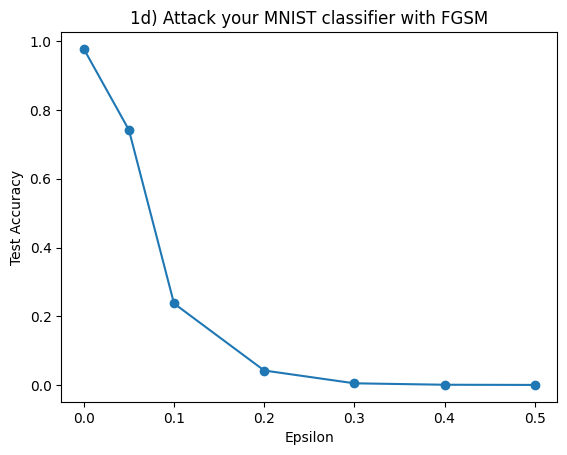

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
def denormalize(x): return x * MNIST_STD + MNIST_MEAN
def renormalize(x): return (x - MNIST_MEAN) / MNIST_STD

def fgsm_attack(model, x_norm, y, epsilon):
    """
    In FGS<M, we directly find the worst input x, prone to the attack in the images
    """
    model.eval()

    #Detaching fix the issue: "Detaching guarantees that gradients won’t accidentally flow back into anything upstream."
    x_pix = denormalize(x_norm).clone().detach().to(next(model.parameters()).device)
    y = y.to(x_pix.device)
    x_pix.requires_grad_(True)

    # Forward + cross entropy loss
    logits = model(renormalize(x_pix))
    loss = F.cross_entropy(logits, y)

    # Backward wrt pixel input
    model.zero_grad(set_to_none=True)
    loss.backward()

    # FGSM
    # FIND GRADIENT
    # THEN TAKE THE DIRECTION OF GRADIENT, MULTIPLIED BY A CONSTANT EPSILON
    grad_sign = x_pix.grad.sign()
    x_adv_pix = torch.clamp(x_pix + epsilon * grad_sign, 0.0, 1.0)

    # Re-normalize for model input
    x_adv_norm = renormalize(x_adv_pix).detach()
    return x_adv_norm


# EVALUATE TESTING DATA
def evaluate(model, loader, epsilon):
    correct, total = 0, 0
    for x, y in loader:

        #Get x input prone to attack
        x, y = x.to(next(model.parameters()).device), y.to(next(model.parameters()).device)
        x_adv = fgsm_attack(model, x, y, epsilon)

        with torch.no_grad():
            preds = model(x_adv).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total

epsilons = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []
for eps in epsilons:
    acc = evaluate(model, test_loader, eps)
    accuracies.append(acc)
    print(f"Epsilon {eps}: accuracy = {acc*100}%")

# Plot accuracy vs epsilon
plt.figure()
plt.plot(epsilons, accuracies, marker="o")
plt.xlabel("Epsilon")
plt.ylabel("Test Accuracy")
plt.title("1d) Attack your MNIST classifier with FGSM")
plt.show()


### NOTE - FGSM attack with respect to the magnitude


FGSM perturbations directly exploit the model’s loss gradient, so even very small $\epsilon$ values cause much sharper accuracy drops than constant offsets or random noise. The accuracy exponentially decays at much faster rate than constant and noise perturbation.

## 1e) Attack your MNIST classifier with Targeted FGSM

Implement the Targeted Fast Gradient Sign Method (TFGSM) attack algorithm and experiment with different values of $\epsilon$. You should write TFGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements TFGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude for each target class:
- A few example images where you were able to successfully cause the classifier to predict the targeted (incorrect) class
- A few sentences about your model's susceptibility to targeted attacks (e.g., are some target classes "easier" to get your model to classify? if you try to perturb images labeled 0 to a target class of 8, does the image get perturbed in an intuitive way?)

Target 0, eps 0.00: 9.92% success
Target 0, eps 0.05: 9.04% success
Target 0, eps 0.10: 5.38% success
Target 0, eps 0.20: 1.37% success
Target 0, eps 0.30: 0.30% success
Target 0, eps 0.40: 0.07% success
Target 0, eps 0.50: 0.03% success
Target 1, eps 0.00: 11.34% success
Target 1, eps 0.05: 8.72% success
Target 1, eps 0.10: 0.46% success
Target 1, eps 0.20: 0.00% success
Target 1, eps 0.30: 0.00% success
Target 1, eps 0.40: 0.00% success
Target 1, eps 0.50: 0.00% success
Target 7, eps 0.00: 10.23% success
Target 7, eps 0.05: 7.44% success
Target 7, eps 0.10: 1.49% success
Target 7, eps 0.20: 0.31% success
Target 7, eps 0.30: 0.02% success
Target 7, eps 0.40: 0.01% success
Target 7, eps 0.50: 0.01% success


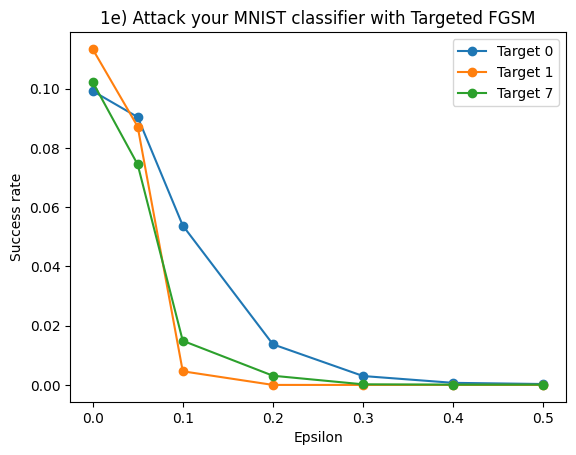

In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
def denormalize(x): return x * MNIST_STD + MNIST_MEAN
def renormalize(x): return (x - MNIST_MEAN) / MNIST_STD

def targeted_fgsm_attack(model, x_norm, y_target, epsilon):
    model.eval()

    x_pix = denormalize(x_norm).clone().detach().to(next(model.parameters()).device)
    y_target = y_target.to(x_pix.device)
    x_pix.requires_grad_(True)

    # Forward & cross entropy loss with targeted label y
    logits = model(renormalize(x_pix))
    loss = F.cross_entropy(logits, y_target) # cross entropy loss with only targeted label y

   # Backward wrt pixel input
    model.zero_grad(set_to_none=True)
    loss.backward()

    # FGSM (but now with targeted labels)
    # FIND GRADIENT
    # THEN TAKE THE DIRECTION OF GRADIENT, MULTIPLIED BY A CONSTANT EPSILON
    grad_sign = x_pix.grad.sign()
    x_adv_pix = torch.clamp(x_pix + epsilon * grad_sign, 0.0, 1.0)

    # Re-normalize for model input
    x_adv_norm = renormalize(x_adv_pix).detach()
    return x_adv_norm

    return renormalize(x_adv_pix).detach()

def evaluate(model, loader, epsilon, target_class):
    total, success = 0, 0
    for x, y in loader:
        x = x.to(next(model.parameters()).device)
        y_target = torch.full_like(y, target_class)
        x_adv = targeted_fgsm_attack(model, x, y_target, epsilon)

        with torch.no_grad():
            preds = model(x_adv).argmax(dim=1)
        success += (preds == y_target.to(preds.device)).sum().item()
        total += y.size(0)

    return success / total

epsilons = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
target_classes = [0, 1, 7]  # pick a few classes to compare
results = {t: [] for t in target_classes}

for t in target_classes:
    for eps in epsilons:
        success = evaluate(model, test_loader, eps, t)
        results[t].append(success)
        print(f"Target {t}, eps {eps:.2f}: {success*100:.2f}% success")

plt.figure()
for t in target_classes:
    plt.plot(epsilons, results[t], marker="o", label=f"Target {t}")
plt.xlabel("Epsilon")
plt.ylabel("Success rate")
plt.title("1e) Attack your MNIST classifier with Targeted FGSM")
plt.legend()
plt.show()

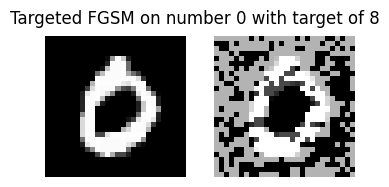

In [26]:
#Perturb 0 by Target 8

eps = 0.7
target_digit = 8

x_batch, y_batch = next(iter(test_loader))
x0 = x_batch[(y_batch == 0)][0:1].to(next(model.parameters()).device)
x_adv = targeted_fgsm_attack(model, x0, torch.tensor([target_digit], device=x0.device), eps)

to_img = lambda t: np.clip(t.squeeze().cpu().numpy() * 0.3081 + 0.1307, 0, 1)

plt.figure(figsize=(4,2))
plt.subplot(1,2,1); plt.imshow(to_img(x0), cmap="gray"); plt.axis("off");
plt.subplot(1,2,2); plt.imshow(to_img(x_adv), cmap="gray"); plt.axis("off");
plt.suptitle(f"Targeted FGSM on number 0 with target of 8")
plt.show()


#### NOTE: A few sentences about your model's susceptibility to targeted attacks, Try perturb '0' with target '8'


MY thoughts: From few experiement, FGSM with Target '1' seems to be easiest to attack the model, since any numbers can be easily perturbed to have the vertical shape like the number '1'. So the model is fooled.

When perturbing '0' with target '8', the perturbed digit still look mostly '0' to human. This demonstrates how targeted FGSM couls be inefficient, compared to FGSM that takes the highest gradient as the perturbed direction.

# Problem 2: Investigating Decision Boundaries

In this problem, you will train a binary classifier for a 2D input vector (is the (x, y) coordinate inside a circle of radius r centered at the origin?).

Since you will know the true decision boundary that the model is trained to approximate, you can generate training data.

Then, you will investigate the model's decision boundary to see how well it matches the true decision boundary.

## 2a) Generate training data

For $x\in R^2$, using the decision rule $f(x) = \begin{cases} 1, &\lvert\lvert x \rvert\rvert_2 \leq 3 \\ 0, & \text{o.w.} \end{cases}$, generate a training, validation, and test set of $[x, f(x)]$ pairs.

**Deliverables:**
- Plot your training set and the true decision boundary

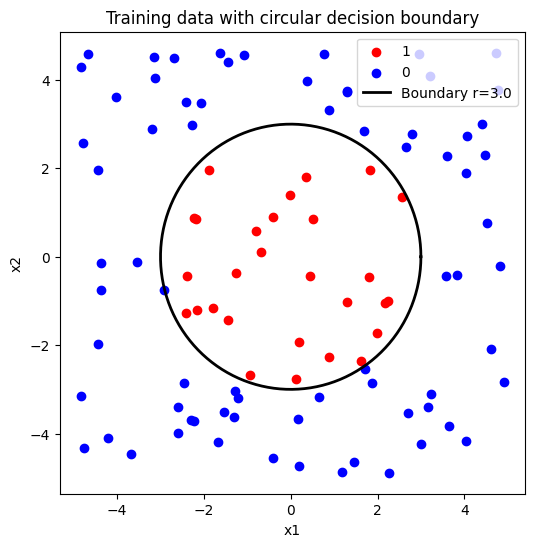

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Generate uniform samples in square [-5,5] x [-5,5]
n_samples = 100
radius = 3.0
X = np.random.uniform(-5, 5, size=(n_samples, 2))

#label is defined by given decision rule
y = (np.linalg.norm(X, axis=1) <= radius).astype(int)
inside = y == 1
outside = y == 0

plt.figure(figsize=(6,6))
plt.scatter(X[inside,0], X[inside,1], color="red", label="1")
plt.scatter(X[outside,0], X[outside,1], color="blue", label="0")

# Plot true decision boundary (circle of radius r)
theta = np.linspace(0, 2*np.pi, 400)
plt.plot(radius*np.cos(theta), radius*np.sin(theta), "k-", linewidth=2, label=f"Boundary r={radius}")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Training data with circular decision boundary")
plt.legend()
plt.show()


## 2b) Train NN classifier

Train a NN classifier on the data you just generated.

**Deliverables**:
- Plot your train & validation loss curves as a function of epoch

Epoch 50 | train 0.1988213062286377 | val 0.31211814284324646
Epoch 100 | train 0.01771201193332672 | val 0.2153976857662201
Epoch 150 | train 0.0026369106490164995 | val 0.2631555199623108
Epoch 200 | train 0.0011538609396666288 | val 0.3083403706550598
Epoch 250 | train 0.000704779289662838 | val 0.33370524644851685
Epoch 300 | train 0.0004829777462873608 | val 0.3496167063713074


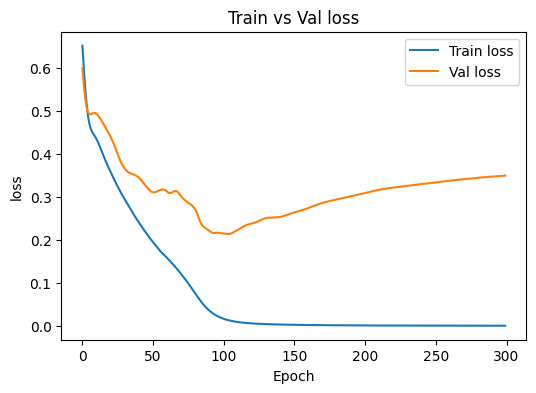

In [33]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# Get training data and labels
n_samples = 100
radius = 3.0
X = np.random.uniform(-5, 5, size=(n_samples, 2)).astype(np.float32)  # float32 inputs
y = (np.linalg.norm(X, axis=1) <= radius).astype(np.float32)

#-----------------------------------------

# train/val split (80/20)
idx = np.random.permutation(len(X))
n_train = int(0.8 * len(X))
train_idx, val_idx = idx[:n_train], idx[n_train:]
X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

# to torch tensors
my_pc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Xt = torch.from_numpy(X_train).to(my_pc)
yt = torch.from_numpy(y_train).unsqueeze(1).to(my_pc)
Xv = torch.from_numpy(X_val).to(my_pc)
yv = torch.from_numpy(y_val).unsqueeze(1).to(my_pc)

#-----------------------------------------
#DEFINE MODEL
#  NN: 2 -> 16 -> 16 -> 1


model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(),
    nn.Linear(16, 16), nn.ReLU(),
    nn.Linear(16, 1)
).to(my_pc)


criterion = nn.BCEWithLogitsLoss()    # for binary classification (expects logits)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)

#--------------------------------
#RUN 300 EPOCH FOR TRAINING AND VALIDATING
EPOCHS = 300

train_losses, val_losses = [], []
for epoch in range(1, EPOCHS + 1):
    model.train()
    opt.zero_grad()
    logits = model(Xt)
    loss = criterion(logits, yt)
    loss.backward()
    opt.step()

    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(Xv), yv)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | train {loss.item()} | val {val_loss.item()}")



plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses,   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.title("Train vs Val loss")
plt.legend()
plt.show()


## 2c) Compare decision boundaries

It is unlikely that your model has learned the true decision boundary perfectly. Here, you will investigate the differences.

**Deliverables**:
- Plot the true and learned decision boundaries
- A few sentences (with relevant figures to illustrate observations) about any differences and how changes to the model architecture or training procedure can impact decision boundaries (e.g., adding regularization, changing the training data generation method, changing the activation functions).

/tmp/ipython-input-3050186835.py:21: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, zz_true, levels=[0.5], colors="black", linewidths=2, linestyles="dashed", label="True")


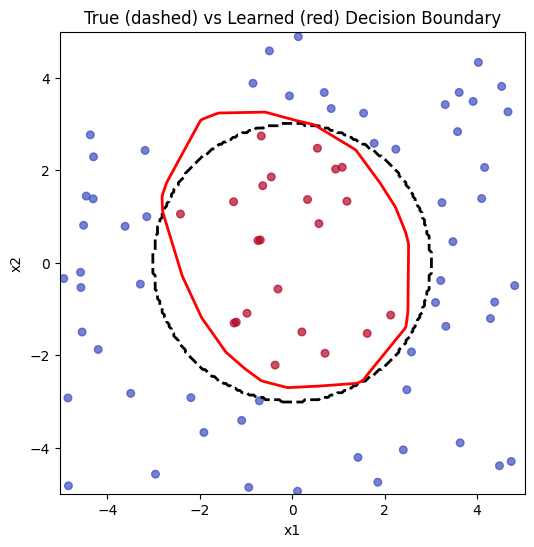

In [35]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def f_true(x, y):
    return x**2 + y**2 - 9


xx, yy = np.meshgrid(np.linspace(-5, 5, 200), np.linspace(-5, 5, 200))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
grid_torch = torch.from_numpy(grid).to(my_pc)

with torch.no_grad():
    zz_model = torch.sigmoid(model(grid_torch)).cpu().numpy().reshape(xx.shape)

zz_true = (f_true(xx, yy) <= 0).astype(np.float32)  # inside circle =1, outside=0

plt.figure(figsize=(6,6))
#  true boundary
plt.contour(xx, yy, zz_true, levels=[0.5], colors="black", linewidths=2, linestyles="dashed", label="True")
# learned boundary
plt.contour(xx, yy, zz_model, levels=[0.5], colors="red", linewidths=2)

# also scatter training points
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="coolwarm", s=30, alpha=0.7)
plt.title("True (dashed) vs Learned (red) Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()


#### FINAL NOTE: how changes to the model architecture or training procedure can impact decision boundaries ???


The current model captures the general circular shape with straight edges and distorted shape.
- If we make the NN model deeper with more layers, the function may get too complex which might overfit the training data and result in a jagged boudndary shape.
- If we use regularization, we might be able to get smoother shape resemblence to the circle, but at a cost of underfitting the data.
- Nonetheless, increase in training data would help the classifier.

### OMIT extra credit problem

# Problem 3: Attack Competition on a Pre-Trained CIFAR-10 Classifier [Extra Credit]

## 3.1 White-Box $l_\infty$-norm Attack

Here, you will have access to the full model (i.e., you know all of its parameters and architecture, you can compute gradients). You should write a function that takes in:
- the model
- a set of images + corresponding labels
- a perturbation magnitude,

and returns a perturbed version of the provided images that will cause the model to have poor classification accuracy.

We provide a template for your attack function and a function for checking the classification accuracy so that you can prototype locally. Once you upload your .ipynb to Gradescope (make sure it is named `hw1.ipynb`), we will run your attack function against some random test images and maintain a leaderboard of the strongest attack (we provide the actual evaluation script below for your convenience). Every student that gets the accuracy below 40% will get some extra credit, and the student with strongest attack will get more extra credit. In case of a tie, we will look at runtime. You can keep updating your submission until the deadline.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import time

Here's a suggested way of getting the CIFAR-10 dataset:

In [ ]:
device = 'cuda'
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Here's the model you'll be attacking (ResNet20):

In [ ]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

While CIFAR-10 images have pixel values $\in [0, 1]$, the model we're attacking was trained on a normalized version of CIFAR-10 (i.e., each image was shifted/scaled by a mean/std). You can attack the model in the original pixel coordinates (that's the space we'll enforce the attack magnitude), but remember that any time you want to query the model, you should first normalize the images according to those settings:

In [ ]:
def normalize(imgs):
  mean = (0.4914, 0.4822, 0.4465)
  std = (0.2023, 0.1994, 0.2010)
  Normalize = transforms.Normalize(mean=mean, std=std)
  return Normalize(imgs)

This function may help you when familiarizing yourself with the dataset and baseline model performance (and shows an example of using the normalize function right before querying the model):

In [ ]:
def quickly_run_model(model, testloader, num_to_show=4):
  dataiter = iter(testloader)

  # `images` coming out of the dataloader are tensors of size (batch, 3, 32, 32)
  # where each pixel is within [0, 1].
  images, labels = next(dataiter)

  model = model.to(device)
  images = images.to(device)
  labels = labels.to(device)

  # The model was trained on a normalized version of the dataset
  # (i.e., each pixel was scaled/shifted by mean and std).
  # ==> we will normalize our images in that same way before querying model
  normalized_images = normalize(images)
  outputs = model(normalized_images)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_to_show)))
  print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}'
                                for j in range(num_to_show)))

quickly_run_model(model, testloader)

The function you will fill in is `white_box_attack`. The autograder expects this exact function name and signature, so make sure those stay the same:

In [ ]:
def white_box_attack(model, raw_images, labels, attack_magnitude):

  # TODO: Fill in this method with your attack algorithm
  # For example, a non-attack would be:
  perturbed_images = raw_images

  return perturbed_images

To help you debug, here's the function we will use to evaluate your `white_box_attack`. This should give 92.6% accuracy when there is no attack. This function is meant to be able to run standalone (i.e., not in a Jupyter notebook where the model/dataset may already be loaded), so feel free to modify it to be more efficient when debugging. We will run your attack against our own replica of this function on Gradescope's servers, so the runtime numbers will likely differ from what you observe locally or on Colab:

In [ ]:
def evaluate_attacked_accuracy(attack_magnitude, attack_fn=white_box_attack, device='cpu'):

  # We will run your attack against this function to establish the leaderboard

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          pin_memory=True)

  model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

  attack_runtime = 0.
  correct = 0
  total = 0
  model.to(device)
  model.eval()
  for raw_images, labels in testloader:

    raw_images = raw_images.to(device)
    labels = labels.to(device)

    attack_runtime_start = time.time()
    normalized_raw_images = Normalize(raw_images)
    perturbed_images = attack_fn(model, raw_images, normalized_raw_images, labels, attack_magnitude)
    attack_runtime_end = time.time()
    attack_runtime += attack_runtime_end - attack_runtime_start

    assert torch.all(perturbed_images <= 1.) and torch.all(perturbed_images >= 0.), "Perturbed images contain pixels outside of [0, 1]."
    assert torch.all(torch.linalg.vector_norm(perturbed_images - raw_images, ord=torch.inf, dim=(1,2,3)) <= attack_magnitude + 1e-6), "Perturbation violates attack magnitude limit."

    # calculate outputs by running images through the network
    with torch.no_grad():
      normalized_perturbed_images = normalize(perturbed_images)
      outputs = model(normalized_perturbed_images)

    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total

  return accuracy, attack_runtime

You can run the above evaluation function as follows:

In [ ]:
# We will enforce that the l_inf norm of the perturbation is <= attack_magnitude
attack_magnitude = 1./255
accuracy, attack_runtime = evaluate_attacked_accuracy(attack_magnitude)
print(f"Accuracy: {robust_accuracy} %")
print(f"Attack Runtime: {attack_runtime} [s]")